In [38]:
#import neccesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\i_zaf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i_zaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\i_zaf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [39]:
import os

# Check if the file exists
print(os.path.isfile('imdb_master.csv'))

True


In [3]:
data = pd.read_csv(r"C:\Users\i_zaf\OneDrive\Υπολογιστής\proigmena_themata\imdb_master.csv", encoding="latin-1", engine = 'python')

In [4]:
#checking i can see a review and the file has the format it is supposed to
data['review'][250]

"Take a clichÃ© story and insert Steve Guttenberg.Need i say anymore?This truly is as bad as you would expect. Sheriff Tom Palmer(Guttenberg)and Anna Montgormery attempt to transform a group of useless,inept kids into a winning soccer team.Lacking originality and direction from the offset it's quite a struggle to maintain any form of interest in this film. Despite my reservations about Guttenbergs acting ability i can safely say that the acting of the rival teams coach is actually worse than Guttenbergs.Previously unimaginable i thought. This type of story of underdogs battling all the way to the top has been done before and better every time than this so called 'film'"

In [5]:
data['label'].value_counts()

label
unsup    50000
neg      25000
pos      25000
Name: count, dtype: int64

In [6]:
data = data[data['label'] != 'unsup']

In [7]:
print(data)

       Unnamed: 0   type                                             review  \
0               0   test  Once again Mr. Costner has dragged out a movie...   
1               1   test  This is an example of why the majority of acti...   
2               2   test  First of all I hate those moronic rappers, who...   
3               3   test  Not even the Beatles could write songs everyon...   
4               4   test  Brass pictures (movies is not a fitting word f...   
...           ...    ...                                                ...   
49995       49995  train  Seeing as the vote average was pretty low, and...   
49996       49996  train  The plot had some wretched, unbelievable twist...   
49997       49997  train  I am amazed at how this movie(and most others ...   
49998       49998  train  A Christmas Together actually came before my t...   
49999       49999  train  Working-class romantic drama from director Mar...   

      label         file  
0       neg      0_2.txt

In [8]:
#pos=1 neg=0
data['label'] = data['label'].replace({'positive': 1, 'negative': 0})

In [9]:
#xrisomopoiw etoimpo set leksewn poy tha ginoun drop apo fixed library kai me to porterstemmer ferno tis lekseis stin riziki toys morfi
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
lemmatizer = WordNetLemmatizer()

In [10]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

In [11]:
#drop axriston lekseon , ola peza , drop special xarakktiron , token ana leksi
def preprocess(review):
    review = BeautifulSoup(review, "html.parser").get_text()
    review = re.sub(r"[^a-zA-Z]", " ", review.lower())
    tokens = word_tokenize(review)
    filtered_tokens = [
    lemmatizer.lemmatize(word, get_wordnet_pos(tag))
    for word, tag in pos_tag(tokens)  
    if word not in stop_words
]
    return filtered_tokens

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\i_zaf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\i_zaf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
data['tokens'] = data['review'].apply(preprocess)

C:\Users\i_zaf\AppData\Local\Temp\ipykernel_30200\3389255198.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text()


In [14]:
#ekpaidefsi word2vec monteloy epeksigisi epilogis parametron sto documentation
w2v_model = Word2Vec(sentences=data['tokens'], vector_size=200, window=5, min_count=5, workers=4)

In [15]:
#metatropi ton kritikon se  vectors kai diaxeirisi axrisimopoiiton leksewn
def vectorize_review(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

In [16]:
data['vector'] = data['tokens'].apply(lambda x: vectorize_review(x, w2v_model, 200))

In [17]:
#proetoimasia gia ekpaidefsi
X = np.stack(data['vector'].values)
y = data['label']

In [18]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
#xrisi svm gia provlepsi
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
 # Train the model on training data
svm_model.fit(X_train, y_train)
# Predict on the test data
y_pred_svm = svm_model.predict(x_test)

In [20]:
#aksiologisi montelou
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Test Accuracy: {:.2f}%".format(accuracy_svm * 100))
print("Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

SVM Test Accuracy: 85.21%
Confusion Matrix (SVM):
 [[6359 1198]
 [1021 6422]]
Classification Report (SVM):
               precision    recall  f1-score   support

         neg       0.86      0.84      0.85      7557
         pos       0.84      0.86      0.85      7443

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



In [21]:
#neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [22]:
from keras import regularizers


In [48]:
nn_model = Sequential([
     Dense(128, input_dim=X_train.shape[1], activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),  
    Dropout(0.3),  
    Dense(64, activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])
r



In [24]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()


y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [57]:

nn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# ekpaidefsi
history = nn_model.fit(X_train, y_train, validation_data=(x_test, y_test), epochs=8, batch_size=100, verbose=1)


Epoch 1/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8230 - loss: 0.6182 - val_accuracy: 0.8357 - val_loss: 0.5387
Epoch 2/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8307 - loss: 0.5382 - val_accuracy: 0.8379 - val_loss: 0.5028
Epoch 3/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8313 - loss: 0.5078 - val_accuracy: 0.8379 - val_loss: 0.4828
Epoch 4/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8294 - loss: 0.4914 - val_accuracy: 0.8387 - val_loss: 0.4688
Epoch 5/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8321 - loss: 0.4805 - val_accuracy: 0.8400 - val_loss: 0.4596
Epoch 6/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8318 - loss: 0.4732 - val_accuracy: 0.8417 - val_loss: 0.4524
Epoch 7/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8355 - loss: 0.4628 - val_accuracy: 0.8413 - val_loss: 0.4474
Epoch 8/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8342 - loss: 0.4578 - val_accuracy: 0.8420 - v

In [51]:
import pickle
import joblib
joblib.dump(data['vector'],'vector.pkl')
joblib.dump(w2v_model,'word2vec.pkl')

['word2vec.pkl']

In [58]:
joblib.dump(nn_model, 'neural.pkl')


['neural.pkl']

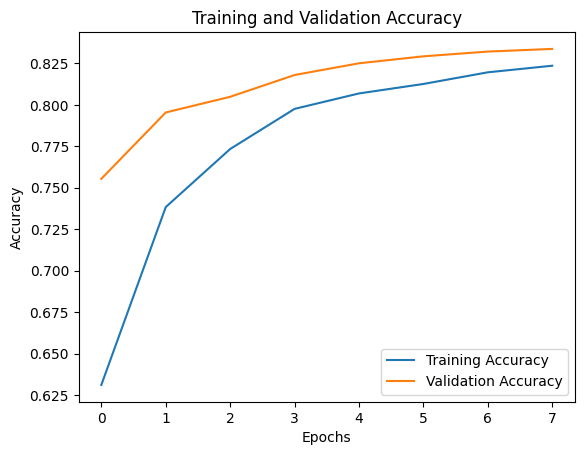

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


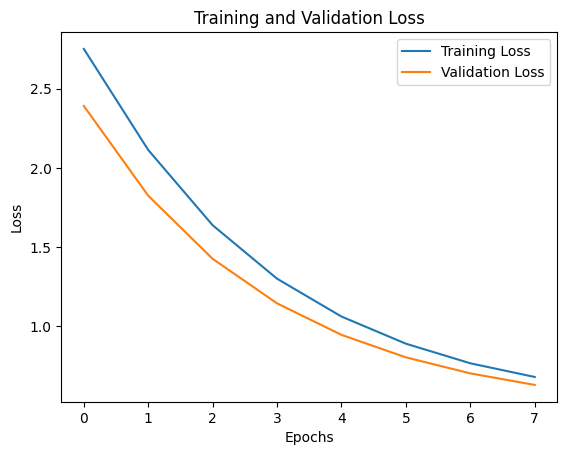

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [55]:
nn_loss, nn_accuracy = nn_model.evaluate(x_test, y_test, verbose=0)
print("Neural Network Test Accuracy: {:.2f}%".format(nn_accuracy * 100))

Neural Network Test Accuracy: 83.37%


In [56]:
#sygkrisi modelon
print("\n--- Model Comparison ---")
print(f"SVM Test Accuracy: {accuracy_svm * 100:.2f}%")
print(f"Neural Network Test Accuracy: {nn_accuracy * 100:.2f}%")


--- Model Comparison ---
SVM Test Accuracy: 85.21%
Neural Network Test Accuracy: 83.37%


In [33]:
#proetoimasia gia xrisi modelou kai dimiourgia web app
from flask import Flask, request, jsonify
import joblib
import numpy as np